<a href="https://colab.research.google.com/github/baizhankyzy/female-directors/blob/main/Project_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Our Goal

To discover trends in the role of female directors in cinema by analyzing their activity across different countries and examining movie databases for specific periods of study. This will include exploring the role of independent cinema as a pathway for women directors. The research will uncover patterns of representation, contributions, and shifts over time.

## Converting JSON file from Wikidata to n-quads format graph

In [63]:
!pip install rdflib
from rdflib import ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
from urllib.parse import quote
import requests
from google.colab import files

# Fetch the JSON data
url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dataset_final.json"
response = requests.get(url)
data = response.json()['results']['bindings']

# Initialize the graph
g = ConjunctiveGraph()

# Define namespaces
wd = Namespace("http://www.wikidata.org/entity/")
wdt = Namespace("http://www.wikidata.org/prop/direct/")
wikidata = URIRef("http://example.org/graph/wikidata")  # Explicitly set graph name

# Add data to the graph
for item in data:
    film = URIRef(item['film']['value'])
    director = URIRef(item['director']['value'])
    release_year = Literal(item['releaseYear']['value'], datatype=RDFS.Literal)
    film_label = Literal(item['filmLabel']['value'], lang='en')
    director_label = Literal(item['directorLabel']['value'], lang='en')

    genre_label = item.get('genreLabel', {}).get('value', "Unknown Genre")
    genre_uri = URIRef(f"http://www.wikidata.org/genre/{quote(genre_label)}")

    country_label = item.get('countryOfBirthLabel', {}).get('value', "Unknown Country")
    country_uri = URIRef(f"http://www.wikidata.org/country/{quote(country_label)}")

    # Avoid blank nodes by always ensuring explicit URIs or Literals
    if isinstance(film, URIRef) and isinstance(director, URIRef):
        # Add RDF quads with the graph name
        g.add((film, wdt.P31, wd.Q11424, wikidata))  # Film type
        g.add((film, RDFS.label, film_label, wikidata))
        g.add((film, wdt.P57, director, wikidata))
        g.add((film, wdt.P577, release_year, wikidata))
        g.add((film, wdt.P136, genre_uri, wikidata))
        g.add((film, wdt.P19, country_uri, wikidata))
        g.add((director, RDFS.label, director_label, wikidata))
        g.add((genre_uri, RDFS.label, Literal(genre_label, lang='en'), wikidata))
        g.add((country_uri, RDFS.label, Literal(country_label, lang='en'), wikidata))

# Serialize the graph to N-Quads
output_file = "wikidata_graph.nq"
g.serialize(output_file, format="nquads")

# Download the file
files.download(output_file)
print(f"Data saved as {output_file} and ready for download.")

<ipython-input-63-41a2ea48f2fe>:13: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = ConjunctiveGraph()


KeyboardInterrupt: 

## Fetching data from DBpedia and converting it into nquads

In [ ]:
!pip install SPARQLWrapper
!pip install rdflib

from SPARQLWrapper import SPARQLWrapper, JSON
from rdflib import ConjunctiveGraph, URIRef, Literal
from rdflib.namespace import RDF, RDFS, XSD
from google.colab import files

# Step 1: Define the endpoint and query
endpoint_url = "https://dbpedia.org/sparql"
sparql_query = """
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dct: <http://purl.org/dc/terms/>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

SELECT DISTINCT ?movie ?movieLabel ?distributor ?distributorLabel ?budget ?boxOffice ?releaseDate ?director ?directorLabel
WHERE {
  ?movie a dbo:Film ;
         dbo:releaseDate ?releaseDate ;
         dbo:distributor ?distributor ;
         dbo:director ?director .

  OPTIONAL { ?movie dbo:budget ?budget . }
  OPTIONAL { ?movie dbo:gross ?boxOffice . }
  OPTIONAL { ?director rdfs:label ?directorLabel . }
  ?movie rdfs:label ?movieLabel .
  ?distributor rdfs:label ?distributorLabel .

  FILTER (xsd:date(?releaseDate) >= "1994-01-01"^^xsd:date && xsd:date(?releaseDate) <= "2024-12-31"^^xsd:date)
  FILTER (lang(?movieLabel) = "en" && lang(?distributorLabel) = "en" && lang(?directorLabel) = "en")
}
ORDER BY ?releaseDate
"""

# Step 2: Send the query to DBpedia
sparql = SPARQLWrapper(endpoint_url)
sparql.setQuery(sparql_query)
sparql.setReturnFormat(JSON)  # Get results in JSON format
results = sparql.query().convert()

# Step 3: Initialize a ConjunctiveGraph for N-Quads conversion
g = ConjunctiveGraph()
dbpedia_graph = URIRef("http://example.org/graph/dbpedia")  # Assign a graph name

# Step 4: Add results to the graph
for result in results["results"]["bindings"]:
    # Extract required fields
    movie = URIRef(result["movie"]["value"])
    release_date = Literal(result["releaseDate"]["value"], datatype=XSD.date)

    # Add required triples
    g.add((movie, RDF.type, URIRef("http://dbpedia.org/ontology/Film"), dbpedia_graph))
    g.add((movie, URIRef("http://dbpedia.org/ontology/releaseDate"), release_date, dbpedia_graph))

    # Add optional triples with checks for empty values
    if "movieLabel" in result and result["movieLabel"]["value"].strip():
        movie_label = Literal(result["movieLabel"]["value"], lang="en")
        g.add((movie, RDFS.label, movie_label, dbpedia_graph))

    if "distributor" in result and "distributorLabel" in result:
        distributor = URIRef(result["distributor"]["value"])
        distributor_label = result["distributorLabel"]["value"].strip()
        if distributor_label:
            g.add((movie, URIRef("http://dbpedia.org/ontology/distributor"), distributor, dbpedia_graph))
            g.add((distributor, RDFS.label, Literal(distributor_label, lang="en"), dbpedia_graph))

    if "budget" in result and result["budget"]["value"].strip():
        budget = Literal(result["budget"]["value"], datatype=XSD.decimal)
        g.add((movie, URIRef("http://dbpedia.org/ontology/budget"), budget, dbpedia_graph))

    if "boxOffice" in result and result["boxOffice"]["value"].strip():
        box_office = Literal(result["boxOffice"]["value"], datatype=XSD.decimal)
        g.add((movie, URIRef("http://dbpedia.org/ontology/gross"), box_office, dbpedia_graph))

    if "director" in result:
        director = URIRef(result["director"]["value"])
        g.add((movie, URIRef("http://dbpedia.org/ontology/director"), director, dbpedia_graph))

        if "directorLabel" in result and result["directorLabel"]["value"].strip():
            director_label = Literal(result["directorLabel"]["value"], lang="en")
            g.add((director, RDFS.label, director_label, dbpedia_graph))

# Step 5: Serialize the graph to N-Quads
output_file = "dbpedia_graph.nq"
g.serialize(output_file, format="nquads")

print(f"N-Quads data saved to {output_file}.")

# Download the file
files.download(output_file)




<ipython-input-5-0c3b5135ccf7>:43: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  g = ConjunctiveGraph()


N-Quads data saved to dbpedia_graph.nq.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Reconciling graphs

In [6]:
!pip install rdflib
!pip install requests
from rdflib import ConjunctiveGraph, URIRef, Namespace, Literal
from rdflib.namespace import OWL
import requests
from google.colab import files

# URLs for the N-Quads files
wikidata_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"
dbpedia_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq"

# Load graphs using ConjunctiveGraph
wikidata_graph = ConjunctiveGraph()
dbpedia_graph = ConjunctiveGraph()

# Download and parse the graphs with error handling
for url, graph in [(wikidata_url, wikidata_graph), (dbpedia_url, dbpedia_graph)]:
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an error if the request fails
        graph.parse(data=response.text, format="nquads")
        print(f"Graph loaded successfully from {url}, contains {len(graph)} triples/quads.")
    except Exception as e:
        print(f"Error parsing graph from {url}: {e}")

# Define namespaces
owl = Namespace("http://www.w3.org/2002/07/owl#")

# Create a reconciliation graph with a named context
reconciliation_context = URIRef("http://example.org/graph/reconciliation")
reconciliation_graph = ConjunctiveGraph()

# Define predicates for labels and directors
wikidata_label_predicate = URIRef("http://www.w3.org/2000/01/rdf-schema#label")
dbpedia_label_predicate = URIRef("http://www.w3.org/2000/01/rdf-schema#label")
wikidata_director_predicate = URIRef("http://www.wikidata.org/prop/direct/P57")
dbpedia_director_predicate = URIRef("http://dbpedia.org/ontology/director")

# Helper function to clean labels (removes "(director)" from DBpedia labels)
def clean_label(label):
    if " (director)" in label:
        return label.replace(" (director)", "").strip()
    return label

# Build an index for DBpedia director labels
dbpedia_director_labels = {}
print("\nBuilding DBpedia director labels index...")
for director, _, label, _ in dbpedia_graph.quads((None, dbpedia_label_predicate, None, None)):
    if director not in dbpedia_director_labels:
        dbpedia_director_labels[director] = clean_label(label)
print(f"Indexed {len(dbpedia_director_labels)} DBpedia directors.")

# Match directors by cleaned labels
match_count = 0
print("\nStarting reconciliation...")
for film, _, director, graph in wikidata_graph.quads((None, wikidata_director_predicate, None, None)):
    for _, _, label, _ in wikidata_graph.quads((director, wikidata_label_predicate, None, None)):
        cleaned_label = clean_label(label)
        # Check against DBpedia index
        for dbpedia_director, dbpedia_label in dbpedia_director_labels.items():
            if cleaned_label.lower() == dbpedia_label.lower():
                print(f"Match Found: {cleaned_label} (Wikidata) == {dbpedia_label} (DBpedia)")
                # Add to reconciliation graph with the specified context
                reconciliation_graph.add((director, OWL.sameAs, dbpedia_director, reconciliation_context))
                match_count += 1

print(f"\nTotal matches found: {match_count}")

# Check if reconciliation graph is empty
if len(reconciliation_graph) == 0:
    print("The reconciliation graph is empty.")
else:
    print(f"The reconciliation graph contains {len(reconciliation_graph)} triples/quads.")

# Serialize the reconciled graph to N-Quads
output_file = "reconciled_graph.nq"
try:
    reconciliation_graph.serialize(output_file, format="nquads")
    print(f"Reconciled graph saved to {output_file}.")
except Exception as e:
    print(f"Error saving reconciled graph: {e}")

# Print all quads in the reconciliation graph
print("\nReconciliation Graph Contents:")
for subject, predicate, obj, graph in reconciliation_graph.quads((None, None, None, None)):
    print(f"Subject: {subject}, Predicate: {predicate}, Object: {obj}, Graph: {graph}")

# Download the file
try:
    files.download(output_file)
    print(f"Data saved as {output_file} and ready for download.")
except Exception as e:
    print(f"Error downloading file: {e}")

<ipython-input-6-4cbaa31bff61>:13: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  wikidata_graph = ConjunctiveGraph()
<ipython-input-6-4cbaa31bff61>:14: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  dbpedia_graph = ConjunctiveGraph()


Graph loaded successfully from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq, contains 117560 triples/quads.
Graph loaded successfully from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq, contains 10952 triples/quads.

Building DBpedia director labels index...
Indexed 3549 DBpedia directors.

Starting reconciliation...


<ipython-input-6-4cbaa31bff61>:31: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  reconciliation_graph = ConjunctiveGraph()


Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Rebecca Miller (Wikidata) == Rebecca Miller (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agnieszka Holland (Wikidata) == Agnieszka Holland (DBpedia)
Match Found: Agniesz

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Data saved as reconciled_graph.nq and ready for download.


# Loading the wikidata graph

Download wikidata graph from github to Google Colab

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
import requests

# GitHub raw URL for the .nq file
github_raw_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"

# Download the nquads file from GitHub
nquads_file = "wikidata_graph.nq"
response = requests.get(github_raw_url)

if response.status_code == 200:
    with open(nquads_file, 'wb') as file:
        file.write(response.content)
    print(f"File {nquads_file} downloaded successfully.")
else:
    print(f"Failed to download file: {response.status_code}")
    response.raise_for_status()

# Load the graph
g = ConjunctiveGraph()
try:
    g.parse(nquads_file, format="nquads")
    print("Graph loaded successfully.")
except Exception as e:
    print(f"Error loading graph: {e}")

# Now you can query the graph


File wikidata_graph.nq downloaded successfully.
Graph loaded successfully.


## Research questions
### 1. How has the number of women directors in feature films changed over the last 30 years, including fluctuations during specific periods and potential external factors such as societal events or industry shifts?




**Filter**

In [ ]:
# Iterate through each year from 1994 to 2024 and count films
print("Year\tNumber of Films")
for year in range(1994, 2025):
    # Construct the query dynamically for each year
    query = f"""
    SELECT (COUNT(?film) AS ?film_count)
    WHERE {{
      ?film <http://www.wikidata.org/prop/direct/P31> <http://www.wikidata.org/entity/Q11424> .
      ?film <http://www.wikidata.org/prop/direct/P577> "{year}"^^<http://www.w3.org/2000/01/rdf-schema#Literal> .
    }}
    """

    # Execute the query
    results = g.query(query)

    # Print the result for the current year
    for row in results:
        print(f"{year}\t{row['film_count']}")

Year	Number of Films
1994	224
1995	247
1996	242
1997	255
1998	292
1999	305
2000	313
2001	364
2002	371
2003	389
2004	438
2005	502
2006	553
2007	586
2008	620
2009	697
2010	614
2011	707
2012	773
2013	827
2014	824
2015	844
2016	1448
2017	897
2018	886
2019	865
2020	627
2021	712
2022	788
2023	706
2024	468


**Mine**

In [ ]:
# Import the csv library
import csv

# Prepare the CSV file
with open('films_per_year.csv', mode='w', newline='') as file:
    writer = csv.writer(file, delimiter=',', quotechar='"', quoting=csv.QUOTE_ALL)
    # Write the column names
    writer.writerow(['year', 'number of films'])

    # Iterate through each year from 1994 to 2024
    for year in range(1994, 2025):
        # Construct the query dynamically for each year
        query = f"""
        SELECT (COUNT(?film) AS ?film_count)
        WHERE {{
          ?film <http://www.wikidata.org/prop/direct/P31> <http://www.wikidata.org/entity/Q11424> .
          ?film <http://www.wikidata.org/prop/direct/P577> "{year}"^^<http://www.w3.org/2000/01/rdf-schema#Literal> .
        }}
        """

        # Execute the query
        results = g.query(query)

        # Extract the result for the current year
        for row in results:
            film_count = row['film_count']  # Extract the film count
            writer.writerow([year, film_count])  # Write year and count to the CSV
            print(f"Year: {year}, Number of Films: {film_count}")

Year: 1994, Number of Films: 224
Year: 1995, Number of Films: 247
Year: 1996, Number of Films: 242
Year: 1997, Number of Films: 255
Year: 1998, Number of Films: 292
Year: 1999, Number of Films: 305
Year: 2000, Number of Films: 313
Year: 2001, Number of Films: 364
Year: 2002, Number of Films: 371
Year: 2003, Number of Films: 389
Year: 2004, Number of Films: 438
Year: 2005, Number of Films: 502
Year: 2006, Number of Films: 553
Year: 2007, Number of Films: 586
Year: 2008, Number of Films: 620
Year: 2009, Number of Films: 697
Year: 2010, Number of Films: 614
Year: 2011, Number of Films: 707
Year: 2012, Number of Films: 773
Year: 2013, Number of Films: 827
Year: 2014, Number of Films: 824
Year: 2015, Number of Films: 844
Year: 2016, Number of Films: 1448
Year: 2017, Number of Films: 897
Year: 2018, Number of Films: 886
Year: 2019, Number of Films: 865
Year: 2020, Number of Films: 627
Year: 2021, Number of Films: 712
Year: 2022, Number of Films: 788
Year: 2023, Number of Films: 706
Year: 202

Pandas

In [ ]:
# pandas
import pandas as pd

# parse the csv into a dataframe
df = pd.read_csv("films_per_year.csv")
# print the first 15 rows
df.head(15)

,year,number of films
0,1994,224
1,1995,247
2,1996,242
3,1997,255
4,1998,292
5,1999,305
6,2000,313
7,2001,364
8,2002,371
9,2003,389


### 1.3 Represent: Profiling and exploration, plotting data

A useful library is **pandas_profiling** that generates reports from a pandas dataframe, including basic statistics on the datasets and a few exploratory visualizations. This is very useful when you are working on big tables with many columns and rows.

In [ ]:
# uncomment and restart the kernel if colab
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas_profiling as pp
pp.ProfileReport(df)

     / 17.9 MB 47.2 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 53.3 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=390938 sha256=f3d57c939b7635230bae7e43741f59598de89293606fdc4af9bcace79c87dd82
  Stored in directory: /tmp/pip-ephem-wheel-cache-onbpx5nz/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e859a949367ba842577b
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=5ea617b48d87444fb415bc6ddb460ed84a6484bd53c7e77e4d307296e7720a0a
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Succe

<ipython-input-19-d7321090094b>:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Seaborn

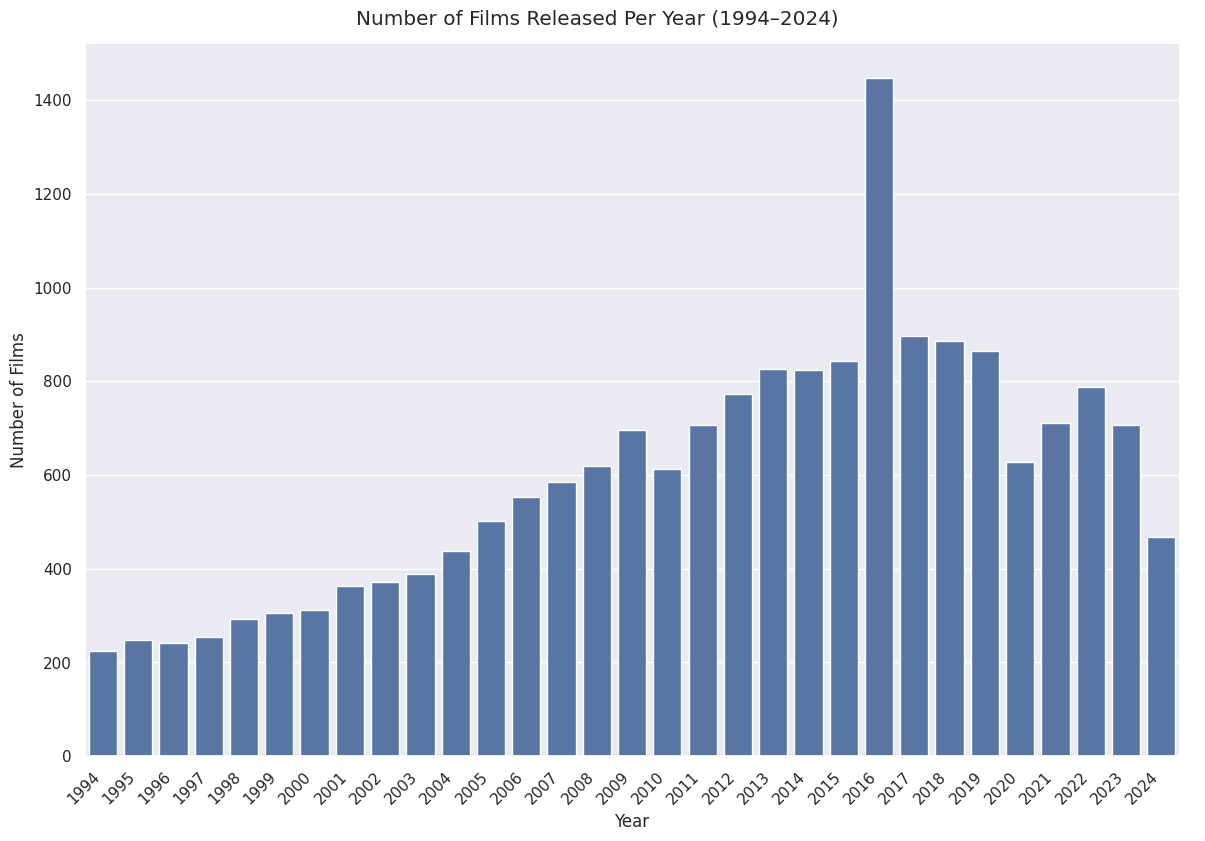

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data from the CSV file into a Pandas DataFrame
periods = pd.read_csv('films_per_year.csv')

# Apply the default theme for Seaborn
sns.set()

# Create a bar chart showing the number of films released each year
my_plot = sns.catplot(
    x="year",              # Year on the horizontal axis
    y="number of films",   # Number of films on the vertical axis
    kind="bar",            # A bar chart
    data=periods,          # The DataFrame containing the data
    height=8,              # Control the height of the plot
    aspect=1.5,            # Control the width-to-height ratio
)

# Add labels and a title
my_plot.set_axis_labels("Year", "Number of Films")
my_plot.fig.suptitle("Number of Films Released Per Year (1994–2024)", y=1.02)

# Rotate the year labels for better readability
plt.xticks(rotation=45, ha='right')  # Rotate 45 degrees, align to the right

# Show the plot
plt.show()

Downloading the picture

In [ ]:
my_plot.savefig("distribution.png")

## **2nd research question**



```
# Which countries have the highest and lowest numbers of women directors in feature films?
```



### Loading Wikidata !!!!

In [ ]:
from rdflib import ConjunctiveGraph, URIRef, Literal, Namespace
from rdflib.namespace import RDF, RDFS
import requests

# GitHub raw URL for the .nq file
github_raw_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"

# Download the nquads file from GitHub
nquads_file = "wikidata_graph.nq"
response = requests.get(github_raw_url)

if response.status_code == 200:
    with open(nquads_file, 'wb') as file:
        file.write(response.content)
    print(f"File {nquads_file} downloaded successfully.")
else:
    print(f"Failed to download file: {response.status_code}")
    response.raise_for_status()

# Load the graph
g = ConjunctiveGraph()
try:
    g.parse(nquads_file, format="nquads")
    print("Graph loaded successfully.")
except Exception as e:
    print(f"Error loading graph: {e}")

# Now you can query the graph


File wikidata_graph.nq downloaded successfully.
Graph loaded successfully.


### Filter

In [ ]:
from rdflib.plugins.sparql import prepareQuery

# Prepare the SPARQL query to count directors per country
query = prepareQuery("""
PREFIX wd: <http://www.wikidata.org/entity/>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT ?countryLabel (COUNT(DISTINCT ?director) AS ?director_count)
WHERE {
  # Instance of film
  ?film wdt:P31 wd:Q11424 .

  # Directed by a director
  ?film wdt:P57 ?director .

  # Country of origin
  ?film wdt:P19 ?country .
  ?country rdfs:label ?countryLabel . # Get country label
  FILTER(LANG(?countryLabel) = "en") # English label
  FILTER(?countryLabel != "Unknown Country") # Exclude Unknown Country
}
GROUP BY ?countryLabel
ORDER BY DESC(?director_count)
""")

# Execute the query
results = g.query(query)

# Print the results
print("Country\tNumber of Women Directors")
for row in results:
    print(f"{row['countryLabel']}\t{row['director_count']}")




Country	Number of Women Directors
Unknown Country	4552
United States of America	833
Germany	630
France	424
Canada	249
Spain	227
United Kingdom	174
Italy	171
India	143
Sweden	126
Russia	118
Switzerland	107
Israel	103
Japan	101
Brazil	99
Poland	96
Argentina	91
Denmark	85
South Korea	75
Netherlands	74
People's Republic of China	71
Austria	70
Czech Republic	70
Australia	68
Iran	68
Finland	57
Turkey	55
Mexico	54
Norway	50
Hungary	48
Belgium	47
Ukraine	46
Portugal	40
Indonesia	38
Peru	37
New Zealand	33
Bulgaria	30
Lebanon	29
Nigeria	29
Serbia	28
Romania	27
Colombia	26
Bosnia and Herzegovina	25
Morocco	24
Chile	20
Taiwan	19
Kenya	18
Pakistan	18
State of Palestine	18
Bangladesh	18
Georgia	17
Greece	17
Estonia	17
Croatia	17
Venezuela	16
Jordan	16
Egypt	15
Slovakia	15
Mandatory Palestine	15
Ireland	15
Uruguay	15
South Africa	15
Kingdom of Denmark	14
Latvia	13
Byzantine Empire	13
Ottoman Empire	13
Judah/Judaea	13
Kingdom of Jerusalem	13
Ayyubid dynasty	13
Mamluk Sultanate	13
Hasmonean dynasty	13


In [ ]:
query = prepareQuery("""
SELECT ?film ?country
WHERE {
  ?film <http://www.wikidata.org/country/> ?country .
}
""")

### 3d Research question

Which genre is the most popular among women director for each of the years from 1994 to 2024?

In [ ]:
#Shows all the genres
print("Year\tGenre\tNumber of Women Directors")

for year in range(1994, 2025):
    # Construct the query dynamically for each year
    query = f"""
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?genreLabel (COUNT(DISTINCT ?director) AS ?director_count)
    WHERE {{
      # Instance of film
      ?film wdt:P31 wd:Q11424 .

      # Directed by a director
      ?film wdt:P57 ?director .

      # Release year matches the current year
      ?film wdt:P577 "{year}"^^<http://www.w3.org/2000/01/rdf-schema#Literal> .

      # Genre classification
      ?film wdt:P136 ?genre .
      ?genre rdfs:label ?genreLabel .

      # Focus on independent cinema and other genres
      FILTER(LANG(?genreLabel) = "en")
    }}
    GROUP BY ?genreLabel
    ORDER BY DESC(?director_count)
    """

    # Execute the query
    results = g.query(query)

    # Print the results for the current year
    for row in results:
        print(f"{year}\t{row['genreLabel']}\t{row['director_count']}")



Year	Genre	Number of Women Directors
1994	drama film	79
1994	documentary film	45
1994	Unknown Genre	35
1994	comedy film	25
1994	comedy drama	13
1994	LGBT-related film	11
1994	romance film	9
1994	children's film	6
1994	biographical film	6
1994	action film	5
1994	thriller film	5
1994	film based on a novel	4
1994	fantasy film	4
1994	erotic film	4
1994	romantic comedy	4
1994	experimental film	4
1994	horror film	4
1994	compilation film	3
1994	teen film	3
1994	Christmas film	2
1994	adventure film	2
1994	crime film	2
1994	buddy film	1
1994	coming-of-age fiction	1
1994	vampire film	1
1994	road movie	1
1994	ghost film	1
1994	science fiction film	1
1994	cyberpunk	1
1994	erotic thriller	1
1994	dance film	1
1994	video art	1
1994	romantic drama	1
1994	animated film	1
1994	queer film	1
1994	parable	1
1994	cinematic fairy tale	1
1994	silent film	1
1994	crossover fiction	1
1994	comedy horror	1
1994	prison film	1
1994	concert film	1
1994	family film	1
1994	fiction film	1
1994	historical film	1
1994	ind

The most popular genre for each year

In [ ]:
print("Year\tMost Popular Genre\tNumber of Films")

for year in range(1994, 2025):
    # Construct the query dynamically for each year
    query = f"""
    PREFIX wd: <http://www.wikidata.org/entity/>
    PREFIX wdt: <http://www.wikidata.org/prop/direct/>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

    SELECT ?genreLabel (COUNT(DISTINCT ?film) AS ?film_count)
    WHERE {{
      # Instance of film
      ?film wdt:P31 wd:Q11424 .

      # Directed by a director
      ?film wdt:P57 ?director .

      # Release year matches the current year
      ?film wdt:P577 "{year}"^^<http://www.w3.org/2000/01/rdf-schema#Literal> .

      # Genre classification
      ?film wdt:P136 ?genre .
      ?genre rdfs:label ?genreLabel .

      # Filter for English language labels
      FILTER(LANG(?genreLabel) = "en")
    }}
    GROUP BY ?genreLabel
    ORDER BY DESC(?film_count)
    LIMIT 1
    """

    # Execute the query
    results = g.query(query)

    # Print the result for the current year
    for row in results:
        print(f"{year}\t{row['genreLabel']}\t{row['film_count']}")

Year	Most Popular Genre	Number of Films
1994	drama film	77
1995	documentary film	64
1996	drama film	94
1997	drama film	79
1998	drama film	96
1999	drama film	93
2000	drama film	99
2001	drama film	137
2002	drama film	138
2003	drama film	128
2004	drama film	155
2005	documentary film	163
2006	drama film	171
2007	drama film	206
2008	drama film	196
2009	drama film	222
2010	drama film	203
2011	drama film	244
2012	drama film	245
2013	documentary film	264
2014	documentary film	254
2015	drama film	272
2016	documentary film	845
2017	drama film	306
2018	drama film	315
2019	drama film	317
2020	drama film	217
2021	documentary film	270
2022	drama film	275
2023	drama film	232
2024	drama film	120


Films and genres of directors from both graphs

In [ ]:
query = """
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?film ?filmLabel ?genre ?genreLabel ?wikidataDirector ?dbpediaDirector
WHERE {
  # Match directors in the reconciliation graph
  ?wikidataDirector owl:sameAs ?dbpediaDirector .

  # Find films and genres in the Wikidata graph
  ?film wdt:P57 ?wikidataDirector ;
        wdt:P136 ?genre .
  ?film rdfs:label ?filmLabel .
  ?genre rdfs:label ?genreLabel .

  # Filter for English labels
  FILTER(LANG(?filmLabel) = "en" && LANG(?genreLabel) = "en")
}
ORDER BY ?filmLabel
"""

# Execute the query
results = combined_graph.query(query)

# Print results with debug information
print("Debugging Query Results:")
for row in results:
    print(f"Film: {row.filmLabel}, Genre: {row.genreLabel}, Wikidata Director: {row.wikidataDirector}, DBpedia Director: {row.dbpediaDirector}")

Debugging Query Results:


What is correlation between budget and box office of the films created by women directors?

In [ ]:
How the funding of women changed through time?

query all films of directors that are in both graphs

In [2]:
!pip install rdflib
from rdflib import ConjunctiveGraph, URIRef, Namespace, Literal
from rdflib.namespace import OWL, RDFS
import requests

# URLs for the N-Quads files
wikidata_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq"
dbpedia_url = "https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq"

# Load graphs using ConjunctiveGraph
wikidata_graph = ConjunctiveGraph()
dbpedia_graph = ConjunctiveGraph()

for url, graph in [(wikidata_url, wikidata_graph), (dbpedia_url, dbpedia_graph)]:
    print(f"Loading graph from {url}...")
    response = requests.get(url)
    response.raise_for_status()
    graph.parse(data=response.text, format="nquads")
    print(f"Graph loaded successfully from {url}, contains {len(graph)} triples/quads.\n")

# Create a reconciliation graph
reconciliation_graph = ConjunctiveGraph()
reconciliation_context = URIRef("http://example.org/graph/reconciliation")

# Helper function to clean labels
def clean_label(label):
    return label.replace(" (director)", "").strip()

# Build an index of DBpedia director labels
dbpedia_director_labels = {}
print("\nBuilding index of DBpedia director labels...")
for director, _, label, _ in dbpedia_graph.quads((None, RDFS.label, None, None)):
    if isinstance(label, Literal) and label.language == "en":
        dbpedia_director_labels[director] = clean_label(str(label))
print(f"Indexed {len(dbpedia_director_labels)} DBpedia directors.\n")

# Match directors by label and create owl:sameAs triples
match_count = 0
print("\nStarting reconciliation process...")
for director, _, label, _ in wikidata_graph.quads((None, RDFS.label, None, None)):
    if isinstance(label, Literal) and label.language == "en":
        cleaned_label = clean_label(str(label))
        for dbpedia_director, dbpedia_label in dbpedia_director_labels.items():
            if cleaned_label.lower() == dbpedia_label.lower():
                print(f"Match found: {cleaned_label} (Wikidata) == {dbpedia_label} (DBpedia)")
                reconciliation_graph.add((director, OWL.sameAs, dbpedia_director, reconciliation_context))
                match_count += 1
print(f"Reconciliation completed. {match_count} matches found.\n")

# Query only films for matched directors
query = """
PREFIX wdt: <http://www.wikidata.org/prop/direct/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>

SELECT DISTINCT ?directorLabel ?filmLabel ?source
WHERE {
  # Match directors reconciled by owl:sameAs
  ?wikidataDirector owl:sameAs ?dbpediaDirector .

  # Retrieve director labels
  OPTIONAL { ?wikidataDirector rdfs:label ?directorLabel FILTER (lang(?directorLabel) = "en") }

  # Films in Wikidata
  {
    ?film wdt:P57 ?wikidataDirector .
    OPTIONAL { ?film rdfs:label ?filmLabel FILTER (lang(?filmLabel) = "en") }
    BIND("Wikidata" AS ?source)
  }
  UNION
  # Films in DBpedia
  {
    ?film dbo:director ?dbpediaDirector .
    OPTIONAL { ?film rdfs:label ?filmLabel FILTER (lang(?filmLabel) = "en") }
    BIND("DBpedia" AS ?source)
  }
}
"""

# Combine graphs into a single graph for querying
unified_graph = ConjunctiveGraph()
for graph in [wikidata_graph, dbpedia_graph, reconciliation_graph]:
    for quad in graph.quads((None, None, None, None)):
        unified_graph.add(quad)

# Run the query
print("Running SPARQL query to retrieve films for matched directors...")
results = unified_graph.query(query)

# Display results and calculate counts
director_film_count = {}
print("\nResults:")
for row in results:
    director_label = row.get("directorLabel")
    film_label = row.get("filmLabel") or "N/A"
    source = row.get("source")

    # Count films for each director
    if director_label:
        if director_label not in director_film_count:
            director_film_count[director_label] = 0
        director_film_count[director_label] += 1

    print(f"Director Label: {director_label}, Film Label: {film_label}, Source: {source}")

# Summary of results
print("\nSummary of Results:")
print(f"Number of unique directors matched: {len(director_film_count)}")
total_films = sum(director_film_count.values())
print(f"Total number of films retrieved: {total_films}")

print("\nTop 5 directors with the most films:")
sorted_directors = sorted(director_film_count.items(), key=lambda x: x[1], reverse=True)
for director, count in sorted_directors[:5]:
    print(f"{director}: {count} films")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 562.4/562.4 kB 28.3 MB/s eta 0:00:00


<ipython-input-2-ac29200a4de4>:11: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  wikidata_graph = ConjunctiveGraph()
<ipython-input-2-ac29200a4de4>:12: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  dbpedia_graph = ConjunctiveGraph()


Loading graph from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq...
Graph loaded successfully from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/wikidata_graph.nq, contains 117560 triples/quads.

Loading graph from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq...
Graph loaded successfully from https://raw.githubusercontent.com/baizhankyzy/female-directors/refs/heads/main/dbpedia_graph.nq, contains 10952 triples/quads.


Building index of DBpedia director labels...
Indexed 3549 DBpedia directors.


Starting reconciliation process...


<ipython-input-2-ac29200a4de4>:22: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  reconciliation_graph = ConjunctiveGraph()


Match found: The Crash Reel (Wikidata) == The Crash Reel (DBpedia)
Match found: Love and Other Catastrophes (Wikidata) == Love and Other Catastrophes (DBpedia)
Match found: Love and Other Catastrophes (Wikidata) == Love and Other Catastrophes (DBpedia)
Match found: Pip Karmel (Wikidata) == Pip Karmel (DBpedia)
Match found: Anjelica Huston (Wikidata) == Anjelica Huston (DBpedia)
Match found: Four for Venice (Wikidata) == Four for Venice (DBpedia)
Match found: Bollywood/Hollywood (Wikidata) == Bollywood/Hollywood (DBpedia)
Match found: Gail Mancuso (Wikidata) == Gail Mancuso (DBpedia)
Match found: Linda Yellen (Wikidata) == Linda Yellen (DBpedia)
Match found: Pat Murphy (Wikidata) == Pat Murphy (DBpedia)
Match found: Rory Kennedy (Wikidata) == Rory Kennedy (DBpedia)
Match found: Tanaz Eshaghian (Wikidata) == Tanaz Eshaghian (DBpedia)
Match found: Anjali Menon (Wikidata) == Anjali Menon (DBpedia)
Match found: Emma-Kate Croghan (Wikidata) == Emma-Kate Croghan (DBpedia)
Match found: Sarah W

<ipython-input-2-ac29200a4de4>:82: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  unified_graph = ConjunctiveGraph()


Running SPARQL query to retrieve films for matched directors...

Results:
Director Label: Gillian Armstrong, Film Label: Women He's Undressed, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Oscar and Lucinda, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Death Defying Acts, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Charlotte Gray, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Little Women, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Unfolding Florence: The Many Lives of Florence Broadhurst, Source: Wikidata
Director Label: Gillian Armstrong, Film Label: Unfolding Florence: The Many Lives of Florence Broadhurst, Source: DBpedia
Director Label: Astra Taylor, Film Label: What Is Democracy?, Source: Wikidata
Director Label: Astra Taylor, Film Label: Zizek!, Source: Wikidata
Director Label: Astra Taylor, Film Label: Examined Life, Source: Wikidata
Director Label: Astra Taylor, Film Label: Zizek!, 

## Sparql endpoint

---
Adding additional data to initial wikidata graph


In [14]:
from SPARQLWrapper import SPARQLWrapper, JSON
import rdflib
from rdflib.namespace import RDFS, XSD

# SPARQL Endpoint
endpoint = "https://query.wikidata.org/sparql"

# SPARQL Query
query = """
SELECT DISTINCT ?director ?directorLabel ?film ?filmLabel
       (YEAR(?releaseDate) AS ?releaseYear) ?distributor ?distributorLabel
       ?genre ?genreLabel
WHERE {
  ?film wdt:P31 wd:Q11424 .  # Instance of film
  ?film wdt:P577 ?releaseDate .  # Release date
  FILTER(YEAR(?releaseDate) >= 1994 && YEAR(?releaseDate) <= 2024)

  ?film wdt:P57 ?director .  # Director
  ?director wdt:P19 ?birthPlace .
  ?birthPlace wdt:P17 wd:Q30 .  # Country: United States

  OPTIONAL { ?film wdt:P750 ?distributor . }  # Distributor
  OPTIONAL { ?film wdt:P136 ?genre . }  # Film genre

  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
ORDER BY ?releaseYear
"""

# Query the endpoint
sparql = SPARQLWrapper(endpoint)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

# Initialize RDF Conjunctive Graph for named graphs
graph = rdflib.ConjunctiveGraph()
graph_name = rdflib.URIRef("http://example.org/additional_graph")

# Add data to the named graph
for result in results['results']['bindings']:
    film_uri = rdflib.URIRef(result['film']['value'])
    film_label = rdflib.Literal(result['filmLabel']['value'])
    release_date = rdflib.Literal(result['releaseYear']['value'], datatype=XSD.gYear)

    director_uri = rdflib.URIRef(result['director']['value'])
    director_label = rdflib.Literal(result['directorLabel']['value'])

    # Optional fields
    distributor_uri = result.get('distributor', {}).get('value', None)
    distributor_label = result.get('distributorLabel', {}).get('value', None)
    genre_uri = result.get('genre', {}).get('value', None)
    genre_label = result.get('genreLabel', {}).get('value', None)

    # Add core triples
    graph.add((film_uri, rdflib.URIRef("http://www.wikidata.org/prop/direct/P57"), director_uri, graph_name))  # Director
    graph.add((film_uri, rdflib.URIRef("http://www.wikidata.org/prop/direct/P577"), release_date, graph_name))  # Release Date

    if distributor_uri:
        graph.add((film_uri, rdflib.URIRef("http://www.wikidata.org/prop/direct/P750"), rdflib.URIRef(distributor_uri), graph_name))  # Distributor
    if genre_uri:
        graph.add((film_uri, rdflib.URIRef("http://www.wikidata.org/prop/direct/P136"), rdflib.URIRef(genre_uri), graph_name))  # Genre

    # Add labels for entities
    graph.add((film_uri, RDFS.label, film_label, graph_name))  # Film Label
    graph.add((director_uri, RDFS.label, director_label, graph_name))  # Director Label

    if distributor_uri and distributor_label:
        graph.add((rdflib.URIRef(distributor_uri), RDFS.label, rdflib.Literal(distributor_label), graph_name))  # Distributor Label

    if genre_uri and genre_label:
        graph.add((rdflib.URIRef(genre_uri), RDFS.label, rdflib.Literal(genre_label), graph_name))  # Genre Label

# Serialize to nQuads format
output_file = "additional_graph.nq"
graph.serialize(destination=output_file, format="nquads")
print(f"Graph saved to {output_file}")

<ipython-input-14-6db4a6262adc>:37: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  graph = rdflib.ConjunctiveGraph()


Graph saved to additional_graph.nq


### Cointing genres

In [20]:
from rdflib import ConjunctiveGraph, URIRef, RDFS
from collections import Counter

# Load the graph
graph_file = "additional_graph.nq"
graph = ConjunctiveGraph()
graph.parse(graph_file, format="nquads")
print(f"Graph loaded with {len(graph)} triples.\n")

# Define key properties (Wikidata)
P57 = URIRef("http://www.wikidata.org/prop/direct/P57")  # Director property
P136 = URIRef("http://www.wikidata.org/prop/direct/P136")  # Genre property

# Containers for analysis
genre_counter = Counter()

# Step 1: Iterate through films and count genres
for film, predicate, director in graph.triples((None, P57, None)):  # Films → Directors
    # Find the genres associated with this film
    for _, _, genre in graph.triples((film, P136, None)):  # Films → Genres
        # Get the human-readable label for the genre
        genre_label = None
        for _, _, label in graph.triples((genre, RDFS.label, None)):
            genre_label = label.lower()
            break  # Only need one label

        if genre_label:
            genre_counter[genre_label] += 1

# Step 2: Output the most common genres
print("Most Popular Genres in Films Directed by Women:")
if genre_counter:
    for genre, count in genre_counter.most_common(10):  # Top 10 genres
        print(f"  {genre.capitalize()}: {count}")
else:
    print("No genre data found in the graph.")

<ipython-input-20-6a975c7ce76f>:6: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  graph = ConjunctiveGraph()


Graph loaded with 77794 triples.

Most Popular Genres in Films Directed by Women:
  Drama film: 3485
  Comedy film: 2059
  Documentary film: 1694
  Action film: 1253
  Horror film: 1163
  Thriller film: 1116
  Crime film: 749
  Romantic comedy: 730
  Comedy drama: 682
  Science fiction film: 672


### Counting top-10 genres per each year

In [44]:
from rdflib import ConjunctiveGraph, URIRef, RDFS
from collections import defaultdict, Counter

# Load the graph
graph_file = "additional_graph.nq"
graph = ConjunctiveGraph()
graph.parse(graph_file, format="nquads")
print(f"Graph loaded with {len(graph)} triples.\n")

# Define key properties (Wikidata)
P57 = URIRef("http://www.wikidata.org/prop/direct/P57")  # Director property
P136 = URIRef("http://www.wikidata.org/prop/direct/P136")  # Genre property
P577 = URIRef("http://www.wikidata.org/prop/direct/P577")  # Release date property

# Container: {year: Counter({genre: count})}
films_by_year_and_genre = defaultdict(Counter)

# Step 1: Iterate through films and count genres per year
for film, _, director in graph.triples((None, P57, None)):  # Films → Directors
    # Extract release year
    release_year = None
    for _, _, date in graph.triples((film, P577, None)):
        try:
            year = int(str(date).split("-")[0])
            if 1994 <= year <= 2024:
                release_year = year
                break
        except ValueError:
            continue  # Skip invalid dates

    if not release_year:
        continue  # Skip films with no valid year

    # Find the genres associated with this film
    for _, _, genre in graph.triples((film, P136, None)):  # Films → Genres
        # Get the human-readable label for the genre
        genre_label = None
        for _, _, label in graph.triples((genre, RDFS.label, None)):
            genre_label = label.lower()
            break  # Only need one label

        if genre_label:
            films_by_year_and_genre[release_year][genre_label] += 1

# Step 2: Output top 10 genres per year
print("Top 10 Genres for Each Year (1994–2024):")
for year in sorted(films_by_year_and_genre):
    print(f"\nYear: {year}")
    top_genres = films_by_year_and_genre[year].most_common(10)  # Top 10 genres
    for genre, count in top_genres:
        print(f"  {genre.capitalize()}: {count}")

<ipython-input-44-39c5c0c6781d>:6: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  graph = ConjunctiveGraph()


Graph loaded with 77794 triples.

Top 10 Genres for Each Year (1994–2024):

Year: 1994
  Drama film: 106
  Comedy film: 82
  Action film: 50
  Thriller film: 37
  Crime film: 33
  Romantic comedy: 25
  Comedy drama: 23
  Horror film: 20
  Fantasy film: 18
  Film based on a novel: 18

Year: 1995
  Drama film: 115
  Comedy film: 49
  Thriller film: 42
  Action film: 42
  Horror film: 30
  Crime film: 30
  Documentary film: 27
  Comedy drama: 19
  Lgbt-related film: 19
  Science fiction film: 17

Year: 1996
  Drama film: 128
  Comedy film: 72
  Action film: 63
  Crime film: 34
  Thriller film: 34
  Science fiction film: 31
  Romantic comedy: 28
  Documentary film: 26
  Comedy drama: 24
  Film based on a novel: 23

Year: 1997
  Drama film: 101
  Comedy film: 60
  Action film: 49
  Crime film: 35
  Thriller film: 26
  Documentary film: 25
  Science fiction film: 24
  Romantic comedy: 23
  Comedy drama: 19
  Lgbt-related film: 15

Year: 1998
  Drama film: 118
  Comedy film: 65
  Action film:

### Distributors for documentaries in 1994**

In [42]:
from rdflib import ConjunctiveGraph, URIRef, RDFS

# Load the graph
graph_file = "additional_graph.nq"
graph = ConjunctiveGraph()
graph.parse(graph_file, format="nquads")
print(f"Graph loaded with {len(graph)} triples.\n")

# Define key properties (Wikidata)
P136 = URIRef("http://www.wikidata.org/prop/direct/P136")  # Genre property
P750 = URIRef("http://www.wikidata.org/prop/direct/P750")  # Distributor property
P577 = URIRef("http://www.wikidata.org/prop/direct/P577")  # Release date property
RDFS_LABEL = RDFS.label  # Human-readable labels

# Target genre and year
target_genre = "documentary film"
target_year = 1994

# Container for results
results = []

# Step 1: Search for films with the genre "Documentary film" and release year 1994
for film, _, genre in graph.triples((None, P136, None)):  # Films → Genres
    # Check if the genre label matches "Documentary film"
    genre_label = None
    for _, _, label in graph.triples((genre, RDFS_LABEL, None)):
        if label.lower() == target_genre.lower():
            genre_label = label
            break

    if genre_label:
        # Check the release year
        release_year = None
        for _, _, date in graph.triples((film, P577, None)):  # Films → Release Date
            try:
                year = int(str(date).split("-")[0])
                if year == target_year:
                    release_year = year
                    break
            except ValueError:
                continue

        if release_year == target_year:
            # Retrieve film label
            film_label = None
            for _, _, label in graph.triples((film, RDFS_LABEL, None)):
                film_label = label
                break
            if not film_label:
                film_label = str(film)  # Fallback to URI

            # Retrieve distributors
            distributors = []
            for _, _, distributor in graph.triples((film, P750, None)):  # Films → Distributors
                distributor_label = None
                for _, _, d_label in graph.triples((distributor, RDFS_LABEL, None)):
                    distributor_label = d_label
                    break
                if not distributor_label:
                    distributor_label = str(distributor)  # Fallback to URI
                distributors.append(distributor_label)

            if not distributors:
                distributors.append("No distributor found")

            # Append the result
            results.append((film_label, distributors))

# Step 2: Output results
print(f"Films with Genre 'Documentary Film' Released in {target_year} and Their Distributors:")
if results:
    for i, (film, distributors) in enumerate(results, start=1):
        print(f"{i}. Film: {film}")
        for distributor in distributors:
            print(f"   Distributor: {distributor}")
else:
    print(f"No films with genre 'Documentary film' released in {target_year} were found.")

<ipython-input-42-44b05dcf8108>:5: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  graph = ConjunctiveGraph()


Graph loaded with 77794 triples.

Films with Genre 'Documentary Film' Released in 1994 and Their Distributors:
1. Film: Gang War: Bangin' In Little Rock
   Distributor: HBO
2. Film: D-Day Remembered
   Distributor: Direct Cinema Limited
3. Film: America Under Siege
   Distributor: No distributor found
4. Film: High school II
   Distributor: No distributor found
5. Film: Coming Out Under Fire
   Distributor: No distributor found
6. Film: Lillehammer ’94: 16 Days of Glory
   Distributor: No distributor found
7. Film: Hoop Dreams
   Distributor: Fine Line Features
   Distributor: Netflix
8. Film: The Goddess Bunny
   Distributor: No distributor found
9. Film: Conversations with Vincent
   Distributor: No distributor found
10. Film: Crumb
   Distributor: Netflix
   Distributor: Sony Pictures Classics
11. Film: Zoo
   Distributor: No distributor found
12. Film: Destiny in Space
   Distributor: Hulu
13. Film: The Maltese Double Cross – Lockerbie
   Distributor: No distributor found
14. Film:

### Independent movies number for each year

#### Filter the data from graph

In [45]:
from rdflib import ConjunctiveGraph, URIRef, RDFS
from collections import defaultdict

# Load the graph
graph_file = "additional_graph.nq"
graph = ConjunctiveGraph()
graph.parse(graph_file, format="nquads")
print(f"Graph loaded with {len(graph)} triples.\n")

# Define key properties (Wikidata)
P57 = URIRef("http://www.wikidata.org/prop/direct/P57")  # Director property
P577 = URIRef("http://www.wikidata.org/prop/direct/P577")  # Release date property
P750 = URIRef("http://www.wikidata.org/prop/direct/P750")  # Distributor property

# Container for counting movies without distributors per year
movies_without_distributor = defaultdict(int)

# Step 1: Iterate through all films and check for missing distributors
for film, _, _ in graph.triples((None, P57, None)):  # Films → Directors
    # Extract release year
    release_year = None
    for _, _, date in graph.triples((film, P577, None)):
        try:
            year = int(str(date).split("-")[0])
            if 1994 <= year <= 2024:
                release_year = year
                break
        except ValueError:
            continue  # Skip invalid dates

    if not release_year:
        continue  # Skip films with no valid year

    # Check if the film has a distributor
    has_distributor = False
    for _, _, distributor in graph.triples((film, P750, None)):  # Films → Distributors
        has_distributor = True
        break

    # If no distributor is found, increment the count for the year
    if not has_distributor:
        movies_without_distributor[release_year] += 1

# Step 2: Output results
print("Number of Movies Without Distributors (1994–2024):")
for year in range(1994, 2025):
    count = movies_without_distributor.get(year, 0)
    print(f"  {year}: {count} movies")

<ipython-input-45-d477ce614003>:6: DeprecationWarning: ConjunctiveGraph is deprecated, use Dataset instead.
  graph = ConjunctiveGraph()


Graph loaded with 77794 triples.

Number of Movies Without Distributors (1994–2024):
  1994: 116 movies
  1995: 160 movies
  1996: 126 movies
  1997: 118 movies
  1998: 128 movies
  1999: 135 movies
  2000: 132 movies
  2001: 147 movies
  2002: 127 movies
  2003: 129 movies
  2004: 145 movies
  2005: 138 movies
  2006: 173 movies
  2007: 169 movies
  2008: 169 movies
  2009: 194 movies
  2010: 171 movies
  2011: 172 movies
  2012: 179 movies
  2013: 197 movies
  2014: 185 movies
  2015: 179 movies
  2016: 224 movies
  2017: 164 movies
  2018: 147 movies
  2019: 169 movies
  2020: 121 movies
  2021: 119 movies
  2022: 95 movies
  2023: 85 movies
  2024: 75 movies


### Mining data to CSV

In [49]:
import csv

# Output file name
output_file = "movies_without_distributors.csv"

# Prepare the CSV file
with open(output_file, mode="w", newline="") as my_file:
    my_writer = csv.writer(my_file, delimiter=",", quotechar='"', quoting=csv.QUOTE_ALL)

    # Write the column names
    my_writer.writerow(['Year', 'Movies Without Distributors'])

    # Access the dictionary results and write them to the CSV
    for year, count in movies_without_distributor.items():
        my_writer.writerow([year, count])

print(f"Data successfully written to '{output_file}'.")

Data successfully written to 'movies_without_distributors.csv'.


### Introducing Pandas

In [51]:
# pandas
import pandas as pd

# parse the csv into a dataframe
df = pd.read_csv("movies_without_distributors.csv")
# print the first 15 rows
df.head(15)

,Year,Movies Without Distributors
0,1998,128
1,1995,160
2,2014,185
3,2012,179
4,2008,169
5,1999,135
6,2000,132
7,2013,197
8,2010,171
9,2011,172


### Represent: Profiling and exploration, plotting data

In [53]:
# uncomment and restart the kernel if colab
! pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip
import pandas_profiling as pp
pp.ProfileReport(df)

     | 17.9 MB 24.5 MB/s 0:00:01
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 41.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 86.6 MB/s eta 0:00:00
  Created wheel for ydata-profiling: filename=ydata_profiling-0.0.dev0-py2.py3-none-any.whl size=390938 sha256=930f374b990f54a2397909e156aa1778b6442d8c05a2d4e3911123e3d85a2d3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-yt2ftlua/wheels/07/29/61/f533cc7cbd0a97efb2d1b94d3254a3e859a949367ba842577b
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27081 sha256=eef2d39ecf6be5436e75254358eacef2679dee76f8e55e2a00befd2a91c1933c
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Succ

<ipython-input-53-d7321090094b>:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling as pp


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Plotting data with seaborn

<ipython-input-55-aa70bde39b8b>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  my_plot = sns.barplot(x="Year", y="Movies Without Distributors", data=df, palette="Blues_d")


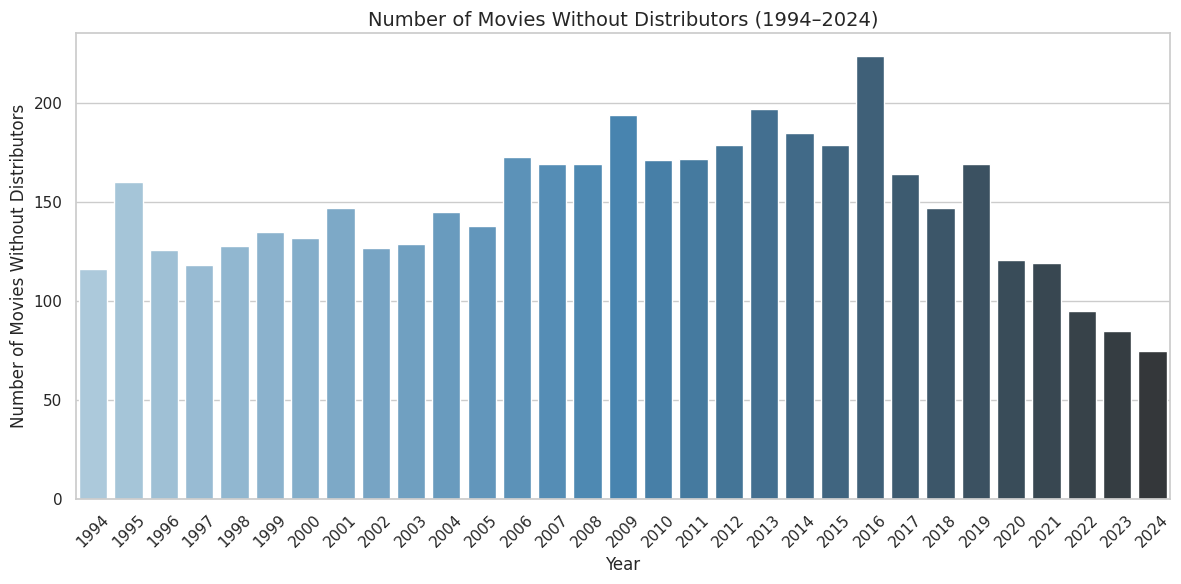

In [55]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the dictionary to a DataFrame
data = {"Year": list(movies_without_distributor.keys()),
        "Movies Without Distributors": list(movies_without_distributor.values())}

df = pd.DataFrame(data)

# Sort the DataFrame by year
df = df.sort_values(by="Year")

# Apply Seaborn theme
sns.set_theme(style="whitegrid")  # Use a clean grid style for better visuals

# Create a bar plot
plt.figure(figsize=(12, 6))  # Adjust the figure size
my_plot = sns.barplot(x="Year", y="Movies Without Distributors", data=df, palette="Blues_d")

# Add plot title and labels
plt.title("Number of Movies Without Distributors (1994–2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Movies Without Distributors", fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show the plot
plt.tight_layout()  # Ensures everything fits within the figure
plt.show()

## 2. Line Chart
	•	Purpose: Display trends over time for the number of movies without distributors.
	•	Best Use: Show progression, increases, or decreases over the years.

Key Features:
	•	A line connects the points representing each year.
	•	Highlights upward or downward trends over time.

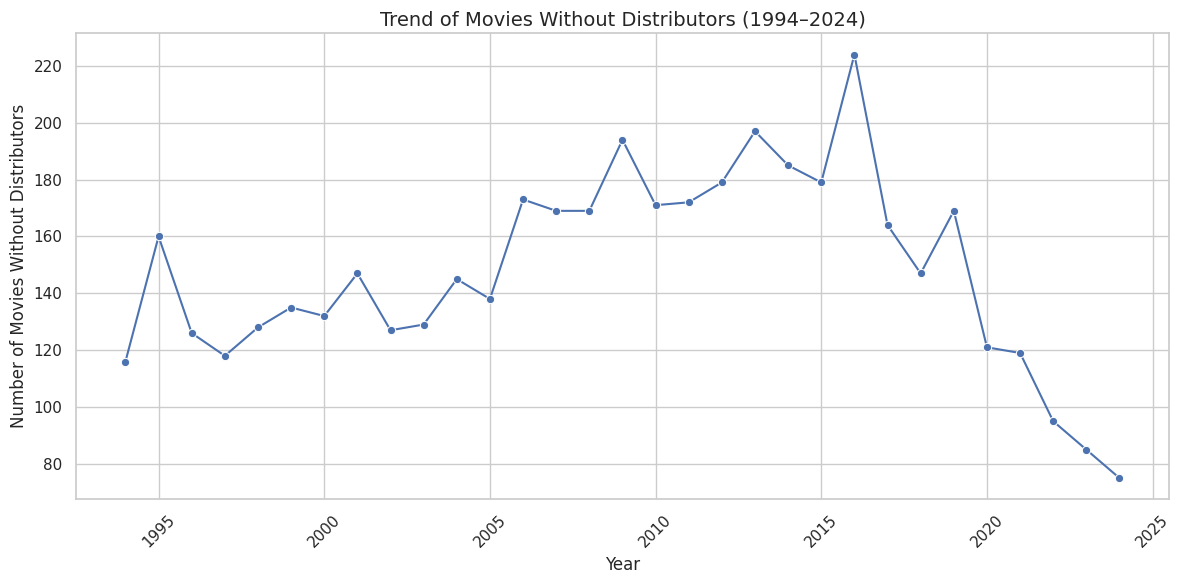

In [56]:
plt.figure(figsize=(12, 6))
sns.lineplot(x="Year", y="Movies Without Distributors", data=df, marker="o", color="b")
plt.title("Trend of Movies Without Distributors (1994–2024)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Number of Movies Without Distributors", fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()